# Homography with KITTI

Going to load some [raw data from KITTI](http://www.cvlibs.net/datasets/kitti/raw_data.php) and project it to a pseudo ground plane...

Rough schematic of vehicle configuration provided here:

<img src='http://www.cvlibs.net/datasets/kitti/images/setup_top_view.png' width='680' align='left'>

In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt
import transforms3d

from utils import data

plt.style.use('seaborn')

In [2]:
calibration, df = data.get_kitti_data(drive='2011_09_26', sequence=1)

In [3]:
df.head()

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,orimode,timestamp,timestamp_00,image_00,timestamp_01,image_01,timestamp_02,image_02,timestamp_03,image_03
2011-09-26 13:02:25.964389445,49.015004,8.434297,116.430328,0.035752,0.009030,-2.608707,-6.811441,-11.275642,13.172717,-0.124753,...,6.0,1.317042e+09,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.074347616,49.014997,8.434280,116.432274,0.036453,0.008009,-2.611005,-6.769916,-11.250719,13.129880,-0.129612,...,6.0,1.317042e+09,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.174598199,49.014991,8.434265,116.435295,0.035908,0.006461,-2.613314,-6.731519,-11.221558,13.084994,-0.140397,...,6.0,1.317042e+09,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.274369566,49.014985,8.434249,116.440720,0.035565,0.005031,-2.615904,-6.684933,-11.198743,13.041455,-0.144497,...,6.0,1.317042e+09,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.384417986,49.014979,8.434233,116.447853,0.034299,0.006470,-2.618804,-6.634209,-11.175295,12.995313,-0.148616,...,6.0,1.317042e+09,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...


Now, we'd like to project images from camera `00` onto a 'pseudo gound-plane'. This pseudo ground plane will be a locally level plane (based on the orientation estimated by the IMU).

In [4]:
d0 = df.iloc[0]
im0 = cv2.imread(d0.image_00)
print(d0)

lat                                                        49.015
lon                                                        8.4343
alt                                                        116.43
roll                                                     0.035752
pitch                                                     0.00903
yaw                                                      -2.60871
vn                                                       -6.81144
ve                                                       -11.2756
vf                                                        13.1727
vl                                                      -0.124753
vu                                                     -0.0329199
ax                                                      -0.445198
ay                                                      0.0429574
az                                                        10.2099
af                                                      -0.340301
al        

(-0.5, 1241.5, 374.5, -0.5)

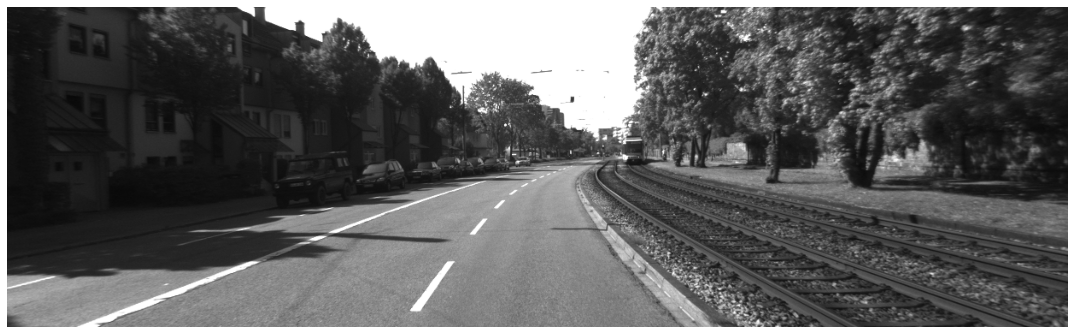

In [5]:
plt.figure(figsize=(19, 19))
plt.imshow(im0, cmap='Greys_r')
plt.axis('off')

In [6]:
def rot_from_rph_rad(r, p, h):
    return transforms3d.euler.euler2mat(r, p, h)
    
def rot_from_rph_deg(r_deg, p_deg, h_deg):
    return rot_from_rph_rad(*np.deg2rad([r_deg, p_deg, h_deg]))

In [7]:
# Compute transform between IMU (I) and mosaic (M) frames. We'll make up the translation
# to the mosaic frame (assuming the IMU is maybe ~1m off the ground).
R_MI = rot_from_rph_rad(d0.roll, d0.pitch, 0.0)
p_MI_M = -np.array([35.0, 0.0, -1.0])  # p_MI_M = -(p_IM_M)

# Break out some calibration transforms to make this easier on ourselves.
R_IV = calibration.R_VI.T
p_IV_I = -(R_IV @ calibration.p_VI_V)

R_VC = calibration.R_CV.T
p_VC_V = -(R_VC @ calibration.p_CV_C)

# Compute transform between camera (C) and mosaic (M) frames.
#     p_MC_M = p_MI_M + p_IV_M + p_VC_M
#            = p_MI_M + R_MI p_IV_I + R_MV p_VC_V
#            = p_MI_M + R_MI (p_IV_I + R_IV p_VC_V)
R_MC = R_MI @ R_IV @ R_VC
p_MC_M = p_MI_M + R_MI @ (p_IV_I + R_IV @ p_VC_V)

(-302.2521292170328, 1478.0995499234464, 374.5, -0.5)

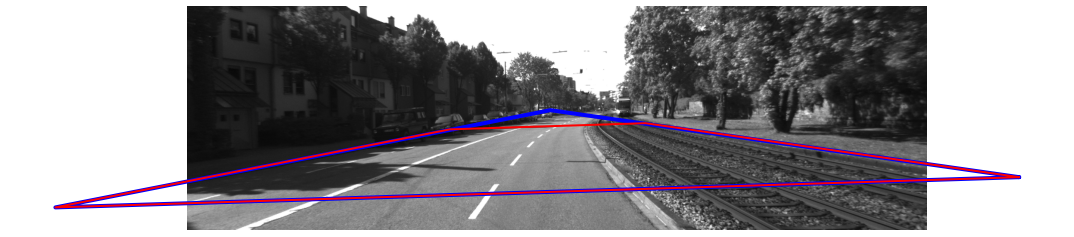

In [8]:
R_CM = R_MC.T
p_CM_C = -(R_MC.T @ p_MC_M)

def _project_00(cal, p):
    u = cal.P_rect_00 @ np.hstack((cal.R_rect_00 @ p, [1.0]))
    u /= u[2]
    return u

pts_Mi_M = [np.array([-25, -10, 0]),
            np.array([-25,  10, 0]),
            np.array([ 10,  10, 0]),
            np.array([ 10, -10, 0])]
uv_Ci_C2d = [_project_00(calibration, p_CM_C + R_CM @ p_Mi_M) for p_Mi_M in pts_Mi_M]
uv_Ci_C2d = np.array(uv_Ci_C2d + [uv_Ci_C2d[0]])

uv_Cj_C2d = np.array([uv_Ci_C2d[0],
                      uv_Ci_C2d[1],
                      _project_00(calibration, p_CM_C + R_CM @ np.array([1000, 0, 0])),
                      uv_Ci_C2d[0]])

fig = plt.figure(figsize=(19, 19))
ax = fig.add_subplot(111)

ax.imshow(im0)
ax.plot(uv_Cj_C2d[:, 0], uv_Cj_C2d[:, 1], 'b', lw=4)
ax.plot(uv_Ci_C2d[:, 0], uv_Ci_C2d[:, 1], 'r', lw=2)

ax.axis('off')